In [51]:
from datetime import datetime
import pandas as pd
import networkx as nx
from collections import Counter
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [131]:
def display_hist(data_dict, bins, title, axis=None, reverse=False):
    data = sorted([v for v in data_dict.values()], reverse=reverse)

    if axis is None:  
        plt.hist(data, bins)
        plt.title(title)
    else:
        axis.hist(data, bins)
        axis.set_title(title)

def display_loglog(data_dict, title, axis, reverse=False):
    data = sorted([v for v in data_dict.values()], reverse=reverse)
    
    if axis is None:
        plt.loglog(data)
        plt.title(title)
    else:
        axis.loglog(data)
        axis.set_title(title)

        
# analyze the distributions of a graph and display them on graphs
def analyze_distribution(G, graph_name, node_frac=0.05, edge_frac=0.05):
    """
    Analyze the distributions of the graph G and any significant connected components.
    :param G: The graph G
    :param graph_name: The name of the graph to be displayed on the plot
    :param node_frac: The minimum fraction of nodes a connected component has to contain 
                      compared to the biggest one to be considered significant; a fraction in range of [0,1]
    :param edge_frac: The minimum fraction of edges a connected component has to contain 
                      compared to the biggest one to be considered significant; a fraction in range of [0,1]
    :return: 
    """
    
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f'Number of conneced components: {len(list(nx.connected_components(G)))}')
    #connected components size distribution
    print("Connected components...")
    connected_components = [c for c in sorted(nx.connected_components(G), key=len, reverse=True)]
    # select large 
    largest_cc = G.subgraph(connected_components[0]).copy()
    print(largest_cc.number_of_nodes(), largest_cc.number_of_edges())
    i = 1
    large_graphs = []
    # select large enough components
    for c in connected_components:
        S = G.subgraph(c).copy()
        # if the current component is large enough, analyze it
        if (S.number_of_nodes() >= largest_cc.number_of_nodes() * node_frac) and (S.number_of_edges() >= largest_cc.number_of_edges() * edge_frac):
            large_graphs.append(S)
        # if there are no more large enough connected components
        else:
            break
    # print(f'Number of conneced components: {len(component_sizes)}')
    # print(f'Connected component sizes: {component_sizes}')
    # print info about large enough connected components
    
    print(f"Number of nodes and edges of connected components of significant size:\n " + 
        f"{[(g.number_of_nodes(), g.number_of_edges()) for g in large_graphs]}")
    
    # plot connected component sizes
    plt.figure(figsize=(15, 5))
    plt.bar([str(i + 1) for i in range(len(large_graphs))], [lg.number_of_nodes() for lg in large_graphs])
    plt.title(f'Significant connected components of {graph_name}')
    plt.show()
    i = 1

    # plot data about large enough graphs
    for S in large_graphs:
        # make the more computationally expensive operations only if graph is small enough
        if S.number_of_edges() < 3000:
            fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))
            # supertitle
            fig.suptitle(f'Connected component {i} with {S.number_of_nodes()} nodes and {S.number_of_edges()} edges')
            # the length of S
            S_len = len(S)
            # degree distribution
            display_loglog({n:(d / S_len) for n, d in S.degree()}, f'Degree distribution', axes[0], True)
            # clustering coefficient distribution
            display_hist(nx.clustering(S), 20, f'Clustering coefficient distribution', axes[1])
            # betweenness centrality distribution
            betweenness = nx.betweenness_centrality(S)
            display_hist(betweenness, 20, f'Betweeness centrality distribution', axes[2])
        else:
            plt.title(f'Connected component {i} with {S.number_of_nodes()} nodes and {S.number_of_edges()} edges')
            # the length of S
            S_len = len(S)
            # degree distribution
            plt.suptitle(f'Connected component {i} with {S.number_of_nodes()} nodes and {S.number_of_edges()} edges')
            display_loglog({n:(d / S_len) for n, d in S.degree()}, f'Degree distribution', None, True)
        
        i += 1
        plt.show()


In [4]:
df = pd.read_csv('Data/BookData.csv')
print(len(df))
df.head()

1999


,id,name,link_name,is_original,status,last_updated,followers,pages,views,description,overall,tags
0,21220,Mother of Learning,mother-of-learning,True,Completed,2023-07-06T17:47:41.0000000+00:00,26426,2932,22166964,<p>Zorian is a teenage mage of humble birth an...,4.84,Time Loop;Adventure;Fantasy;Mystery;Magic
1,36735,The Perfect Run,the-perfect-run,True,Completed,2021-10-16T14:01:38.0000000+00:00,17935,1686,13095571,<p><strong>The Perfect Run is now available on...,4.81,Time Loop;Anti-Hero Lead;Super Heroes;Comedy;M...
2,21410,Super Minion,super-minion,True,Hiatus,2024-11-10T18:58:55.0000000+00:00,18042,1053,6713087,"<p>Fortress City has Super Villains, who have ...",4.81,Villainous Lead;Super Heroes;Non-Human Lead;Sc...
3,63759,Super Supportive,super-supportive,True,Ongoing,2025-04-10T07:55:31.0000000+00:00,30682,3945,21510967,<p><strong>Readers can expect:</strong><em> </...,4.80,Sci-fi;Slice of Life;Fantasy;School Life;Magic...
4,65629,The Game at Carousel: A Horror Movie LitRPG,the-game-at-carousel-a-horror-movie-litrpg,True,Stub,2025-04-09T20:34:05.0000000+00:00,9281,2329,3693330,"<p><a href=""https://www.amazon.com/gp/product/...",4.81,LitRPG;Urban Fantasy;Progression;Strategy;Male...


In [11]:
# drop unnecessary columns
df = df.drop(["name", "link_name", "description"], axis=1)
# convert string to datetime
df['last_updated'] = df['last_updated'].apply(lambda t: datetime.strptime(t.split('.')[0], '%Y-%m-%dT%H:%M:%S'))

df.head()

,id,is_original,status,last_updated,followers,pages,views,overall,tags
0,21220,True,Completed,2023-07-06 17:47:41,26426,2932,22166964,4.84,Time Loop;Adventure;Fantasy;Mystery;Magic
1,36735,True,Completed,2021-10-16 14:01:38,17935,1686,13095571,4.81,Time Loop;Anti-Hero Lead;Super Heroes;Comedy;M...
2,21410,True,Hiatus,2024-11-10 18:58:55,18042,1053,6713087,4.81,Villainous Lead;Super Heroes;Non-Human Lead;Sc...
3,63759,True,Ongoing,2025-04-10 07:55:31,30682,3945,21510967,4.80,Sci-fi;Slice of Life;Fantasy;School Life;Magic...
4,65629,True,Stub,2025-04-09 20:34:05,9281,2329,3693330,4.81,LitRPG;Urban Fantasy;Progression;Strategy;Male...


In [35]:
# create a structure to more easily access nodes by tag
tags_dict = {}
# fill the tags that don't have a value with the empty string
df['tags'] = df['tags'].fillna('')
for _, row in df.iterrows():
    tags = row['tags'].split(';')
    for tag in tags:
        if tag in tags_dict:
            tags_dict[tag].add(row['id'])
        else:
            tags_dict[tag] = {row['id'], }


# make the id the index of the dataframe
df['id'] = df['id'].apply(str)
df = df.set_index('id')

In [115]:
# find and return all the entries that share at least nr_common_tags with 
# current entry
def tag_connections(df, id, nr_common_tags = 3):
    """
    Return a list containing the ids of entries that share at least nr_common_tags number of tags with the entry
    denoted by id.
    
    :param df: The dataframe the entry with id id is part of
    :param id: The id of the current entry to compare against
    :param nr_common_tags: The number of common tags an entry has to have with current one to be included in the result
    :return: The list of qualifying entries containing their ids
    """
    tags = df.loc[id].tags.split(';')
    common = []
    for tag in tags:
        common.extend(tags_dict[tag])

    common = Counter(common)

    # remove self from the list
    del common[id]

    result = []
    for key in common:
        if common[key] >= nr_common_tags:
            result.append(key)
    
    return result

In [113]:
def apply_additional_condition(row, rows, col, threshold, threshold_type):
    """
    Apply an additional condition to rows, filtering them based on the value of a column from row.

    :param row: The row of the current entry
    :param rows: The qualifying rows to filter; DataFrame from Pandas
    :param col: The name of the column to filter by
    :param threshold: The threshold by which to filter; all rows will be qualified if rows[col] is in range
                      [row[col] - threshold,row[col] + threshold]
    :param threshold_type: The type of the threshold; value of 'p' or 'a'
        -if 'p': threshold is set to row[col] * threshold; original threshold should be a fraction in range [0, 1]
        -if 'a': threshold is taken as is
    :return: A new DataFrame containing the qualifying rows
    """
    # percentage based threshold
    if threshold_type == 'p':
        # determine the absolute value of the threshold
        threshold = row[col] * threshold
        
    # absolute value based threshold
    rows = rows[rows[col].between(row[col] - threshold, row[col] + threshold)]

    return rows

# additional conditions format: [[col_name, threshold, threshold_type], ...]
# threshold type: 'p' (percentage) or 'a' (absolute)
def create_graph(df, tags_dict, name, nr_common_tags = 3, additional_conditions = []):
    """
    Create a graph where nodes are the rows from df and a connection is formed between two rows if enough
    tags are shared and the data rows satisfy the additional conditions. Saves the graph in gml format with
    the given name after creation.

    :param df: The dataframe to convert to a graph
    :param tags_dict: A dictionary which has the keys as the possible tags with values being sets 
                      containing the ids of all entries that have that tag
    :param name: The name by which to save the new graph
    :param nr_common_tags: The number of tags a two rows have to have in common to create a connection
    :param additional_contitions: A list of triplets of the form [col_name, threshold, threshold_type] which
                                  denote additional conditions for the forming of connections between nodes,
                                  passed to the apply_additional_condition function
    """
    # create empty graph and add all nodes from the df
    adj_dict = {}
    
    
    for id in df.index:
        common = tag_connections(df, id, nr_common_tags)
        
        # apply additional conditions
        if len(additional_conditions) > 0:
            # select current row
            row = df.loc[id]
            # select all the rows that are in common with this one
            rows = df.loc[common]
            # apply all the conditions
            for cond in additional_conditions:
                rows = apply_additional_condition(row, rows, *cond)

            # get only the ids
            common = list(rows.index)
        # TODO: Add additional_conditions in here
        # add the necessary edges
        adj_dict[id] = common

    G = nx.Graph(adj_dict)

    nx.write_gml(G, f'Networks/{name}.gml')

    return G

Creating...
Analyzing...
Number of nodes: 1999
Number of edges: 2233
Number of conneced components: 736
Connected components...
295 616
Number of nodes and edges of connected components of significant size:
 [(295, 616), (280, 582), (45, 82), (32, 57), (31, 48), (25, 64), (24, 40), (23, 45)]


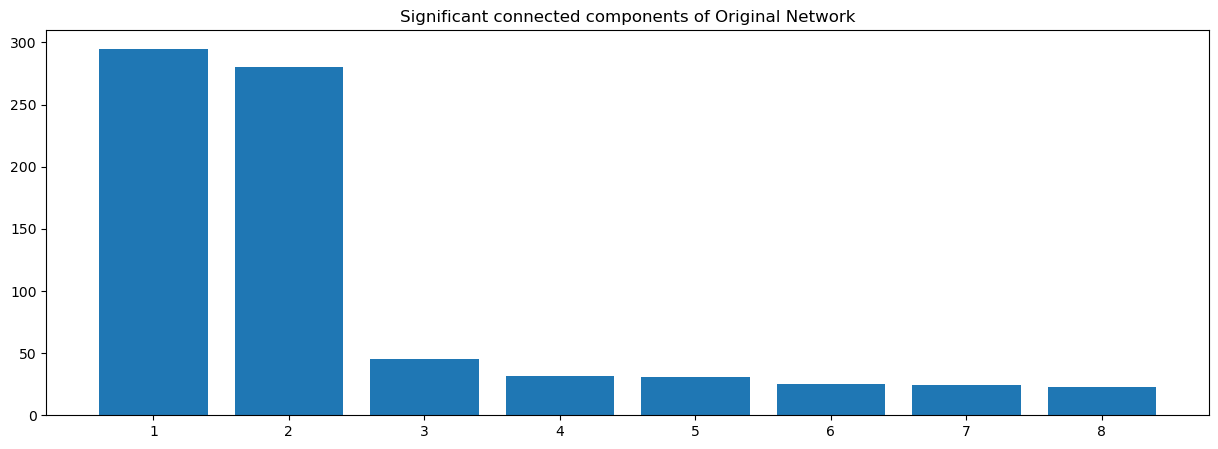

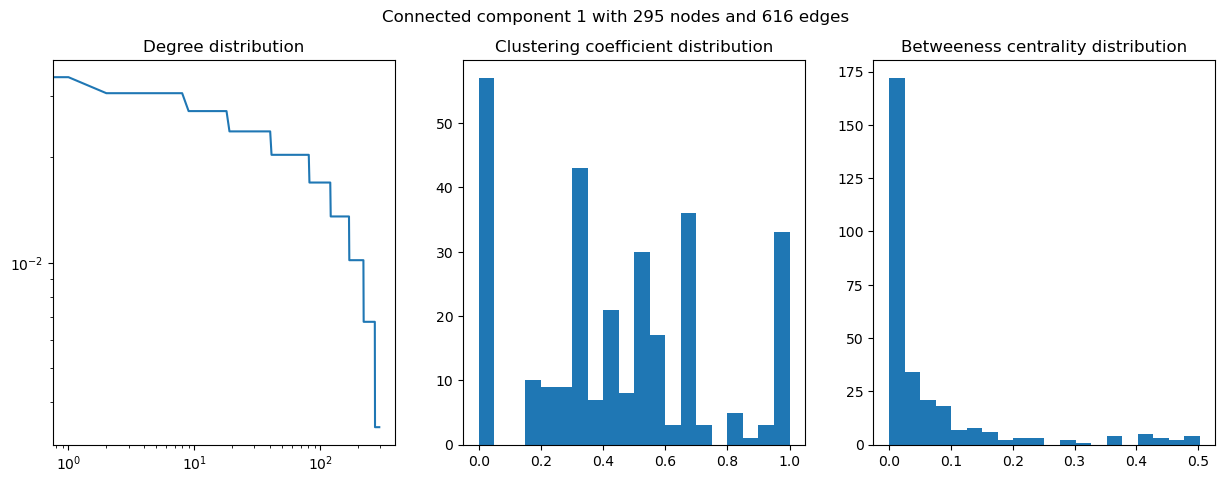

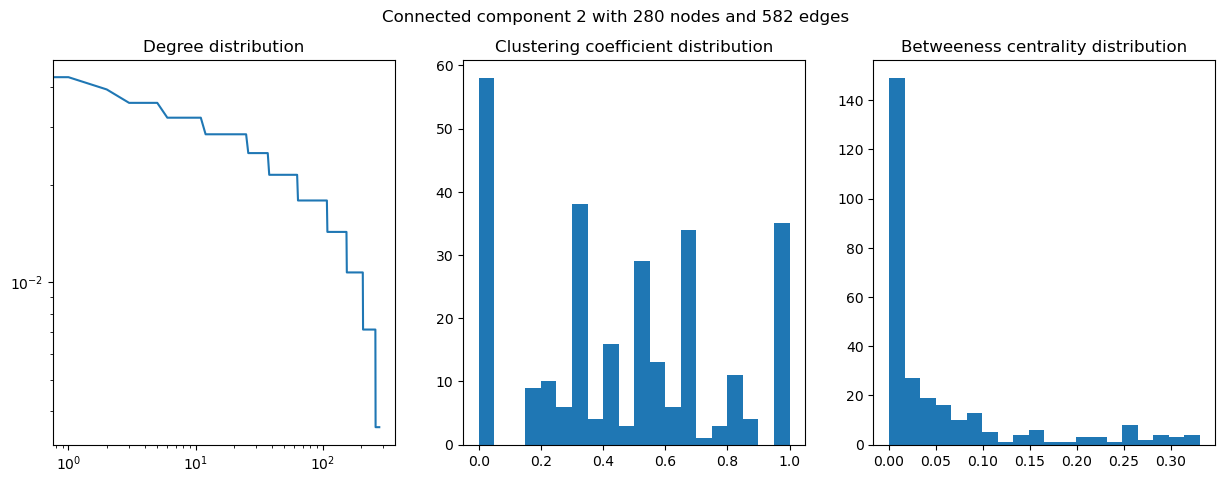

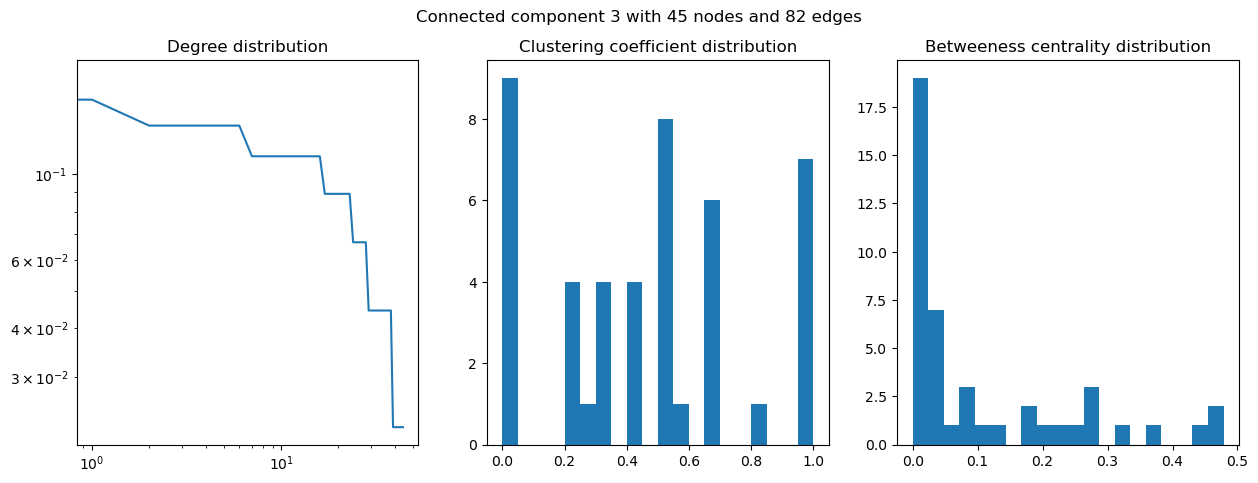

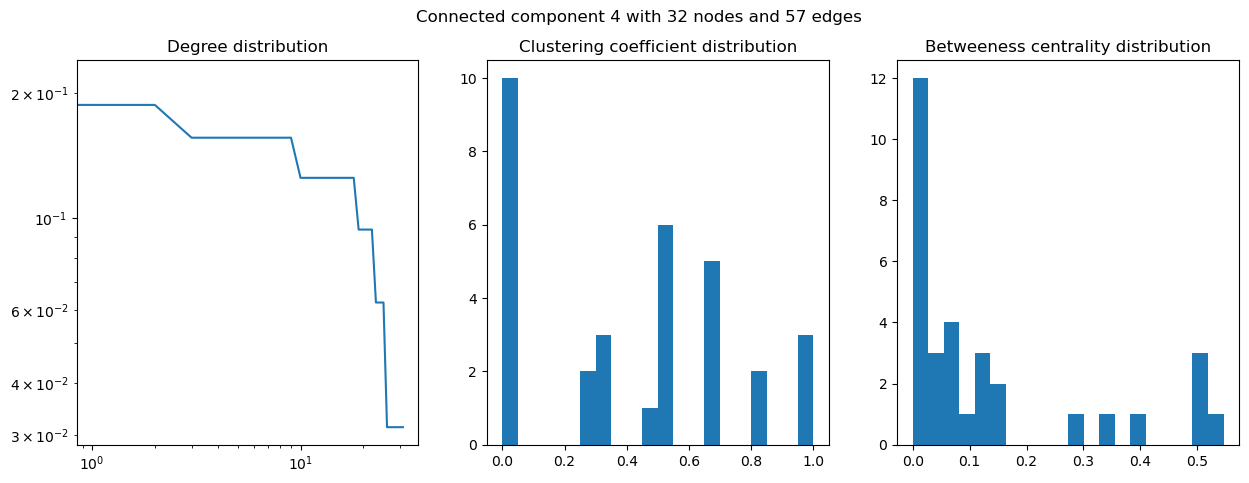

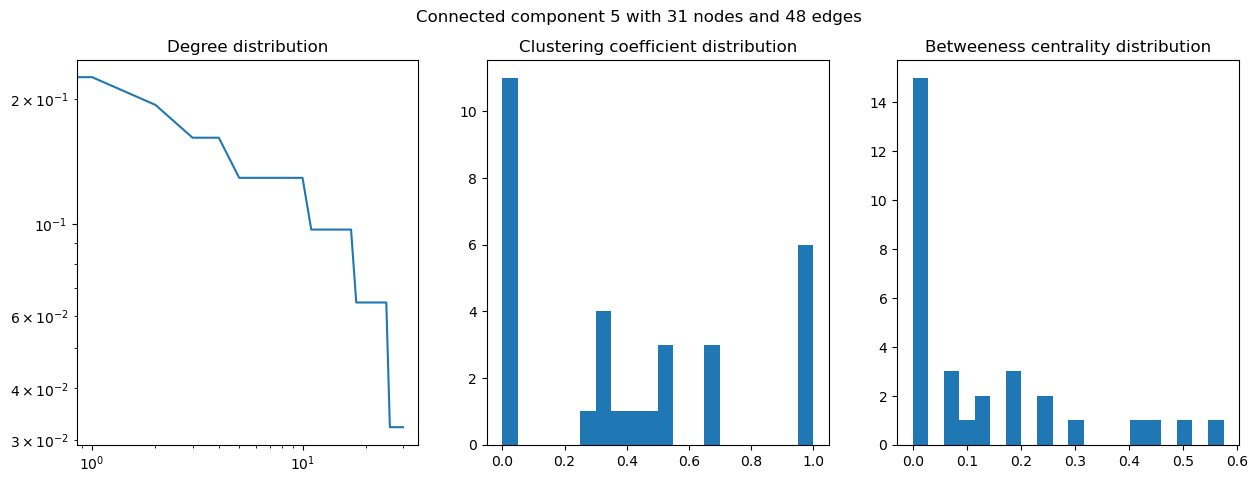

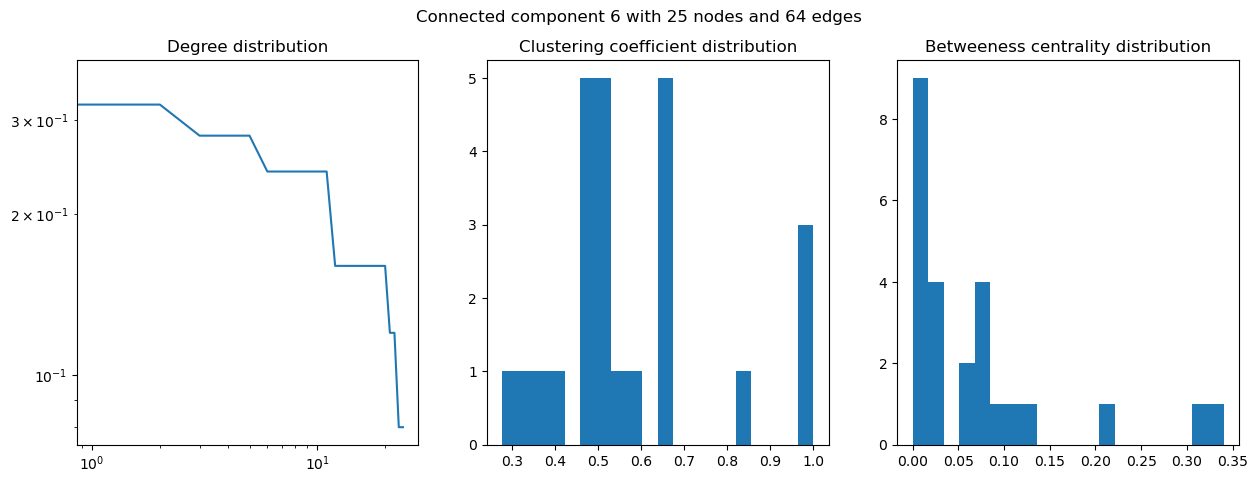

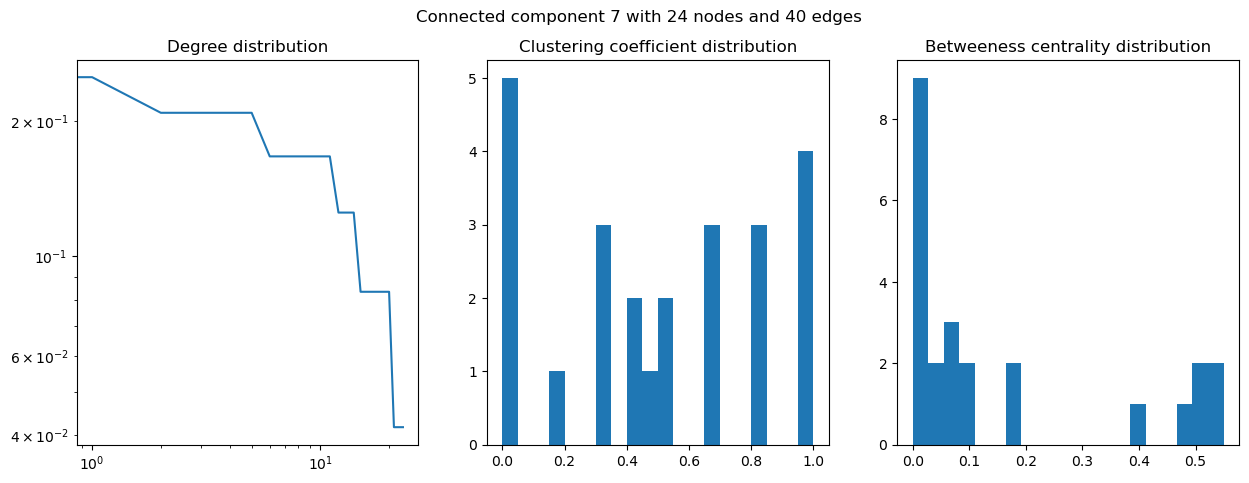

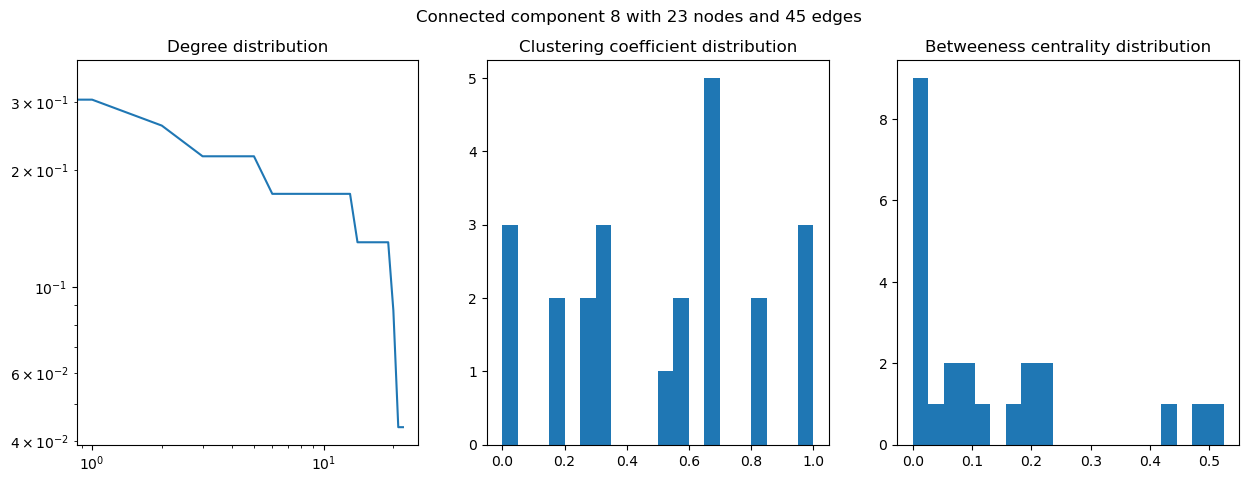

In [118]:
print("Creating...")
G = create_graph(df, tags_dict, 't3_r007p_p007p_f007p', 3, [['overall', 0.07, 'p'], ['pages', 0.07, 'p'], ['followers', 0.07, 'p']])
# analyze newly created graph
print("Analyzing...")
analyze_distribution(G, 'Original Network')


Creating...
Analyzing...
Number of nodes: 1999
Number of edges: 50356
Number of conneced components: 46
Connected components...
1899 50161
Number of nodes and edges of connected components of significant size:
 [(1899, 50161)]


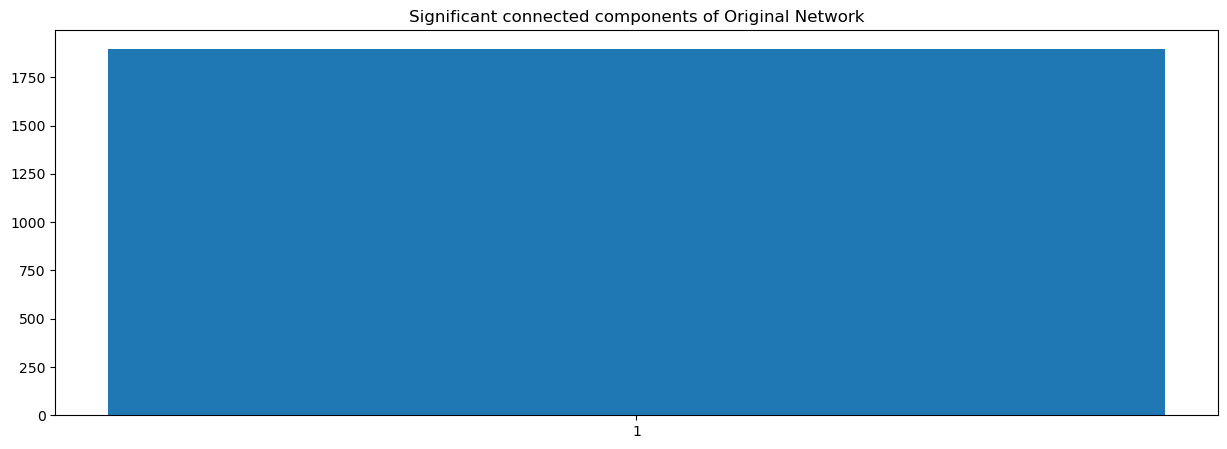

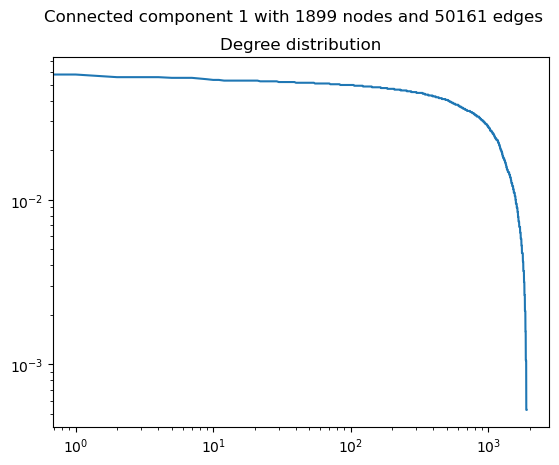

In [132]:
print("Creating...")
G = create_graph(df, tags_dict, 't3_r007p_p007p', 3, [['overall', 0.07, 'p'], ['pages', 0.07, 'p']])
# analyze newly created graph
print("Analyzing...")
analyze_distribution(G, 'Original Network')


Creating...
Analyzing...
Number of nodes: 1999
Number of edges: 58870
Number of conneced components: 41
Connected components...
1939 58842
Number of nodes and edges of connected components of significant size:
 [(1939, 58842)]


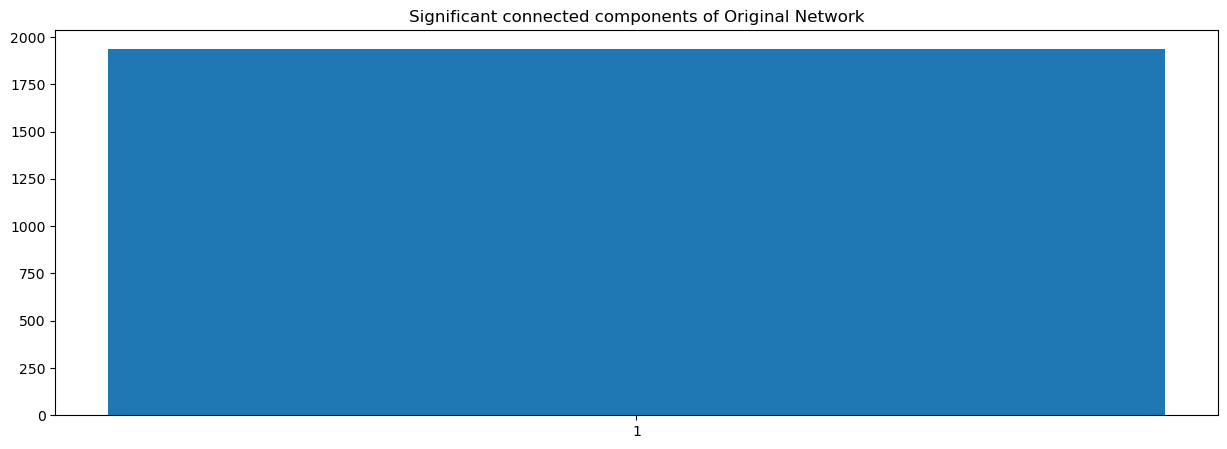

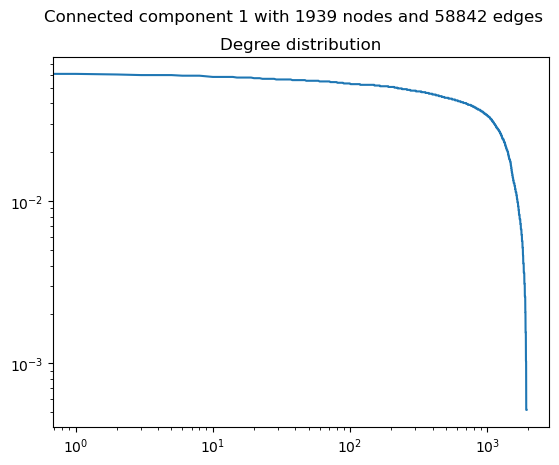

In [133]:
print("Creating...")
G = create_graph(df, tags_dict, 't3_r007p_f007p', 3, [['overall', 0.07, 'p'], ['followers', 0.07, 'p']])
# analyze newly created graph
print("Analyzing...")
analyze_distribution(G, 'Original Network')


Creating...
Analyzing...
Number of nodes: 1999
Number of edges: 2310
Number of conneced components: 717
Connected components...
305 665
Number of nodes and edges of connected components of significant size:
 [(305, 665), (281, 598), (45, 84), (35, 52), (32, 59), (31, 51), (27, 43), (25, 64), (24, 40), (23, 46)]


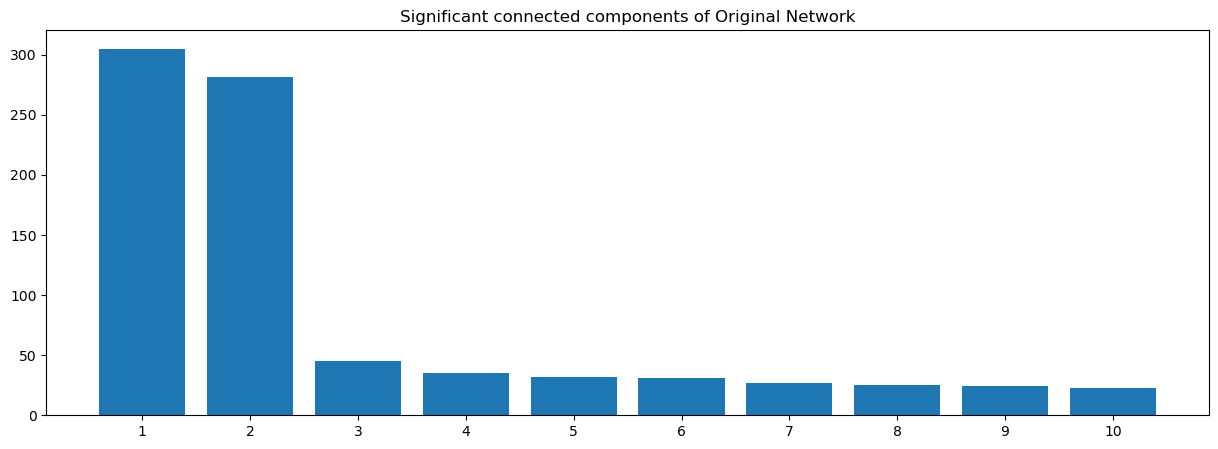

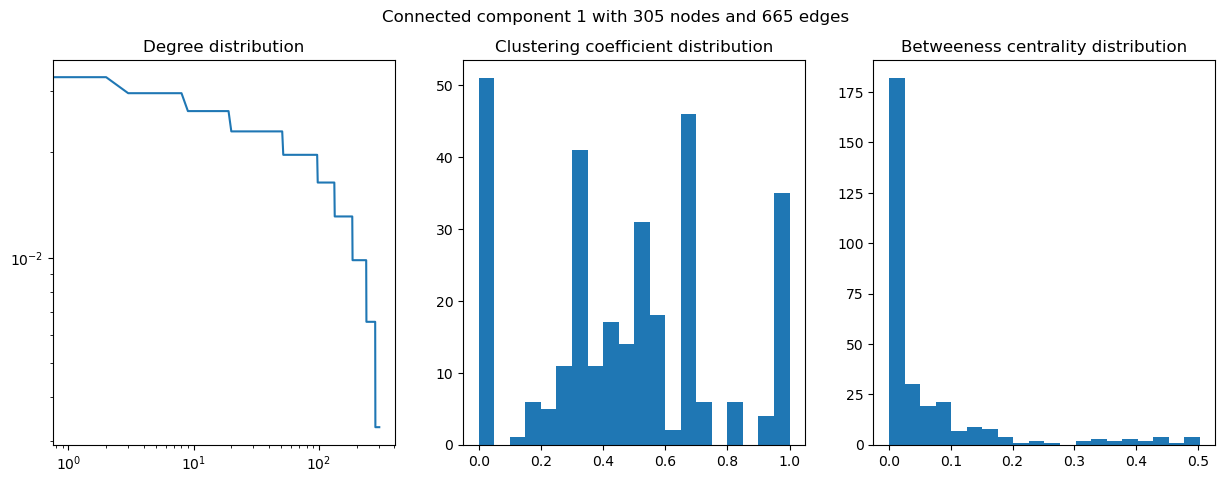

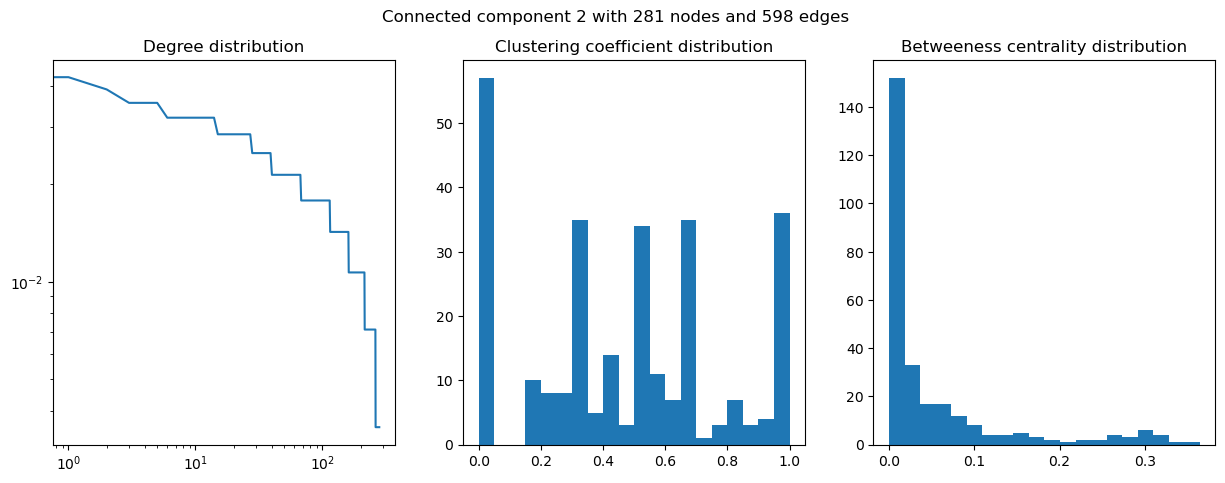

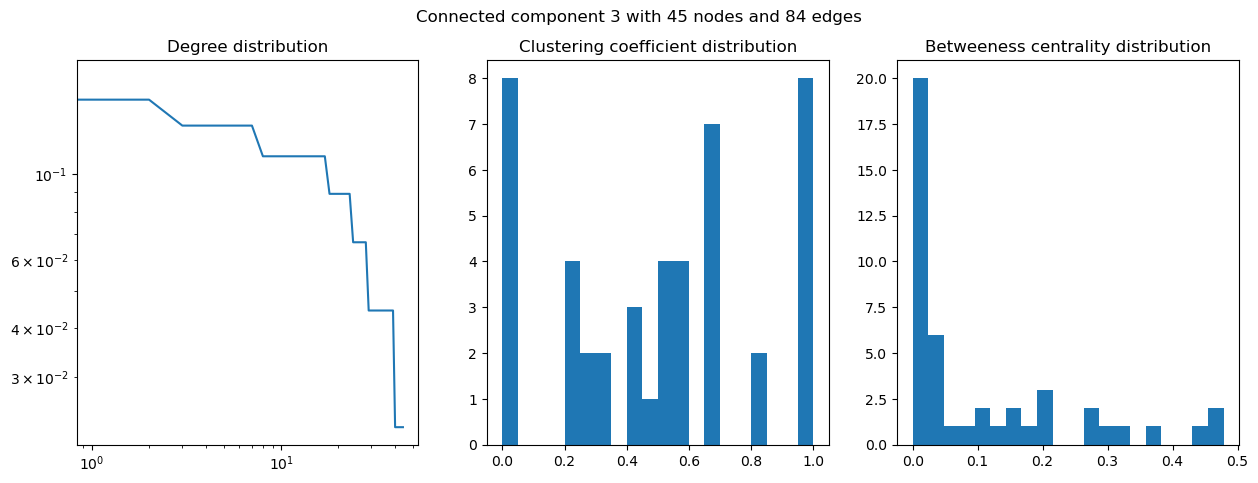

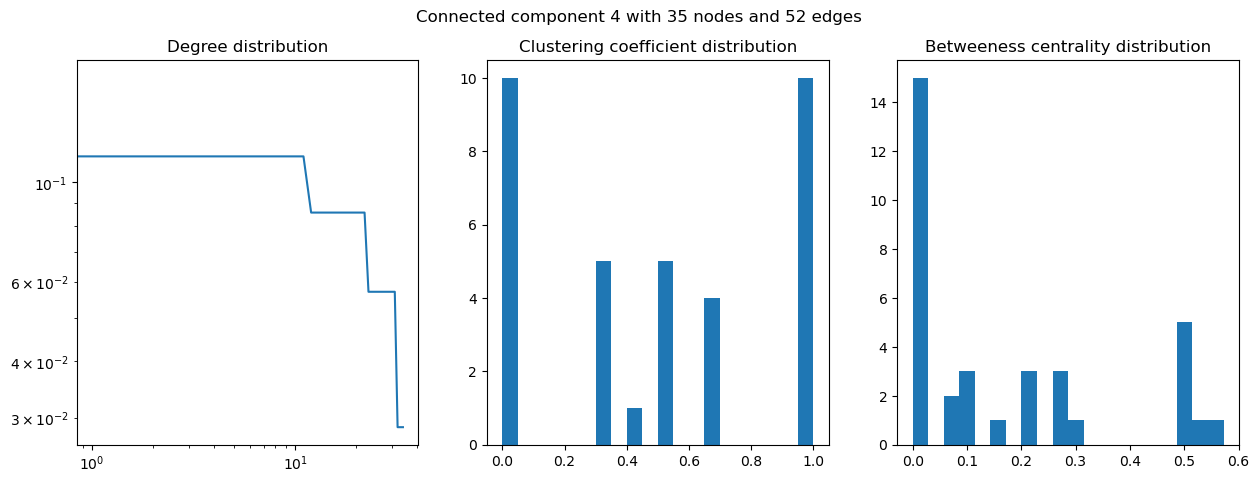

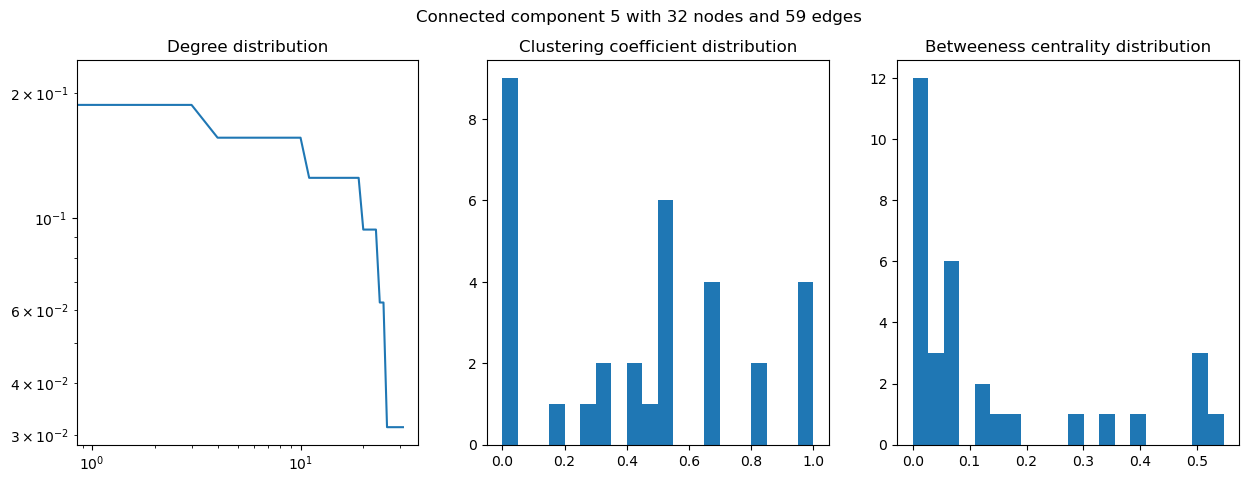

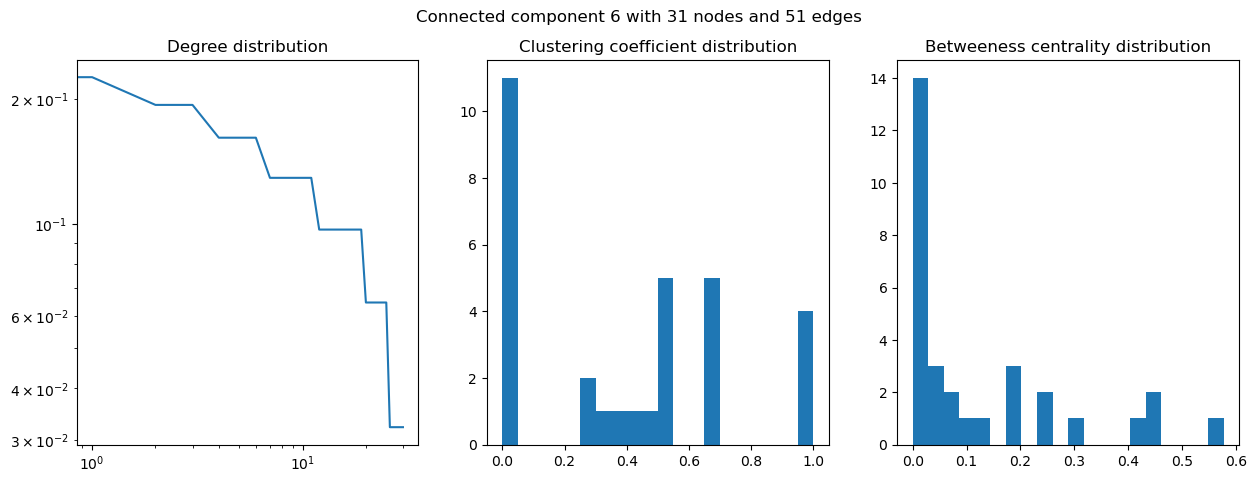

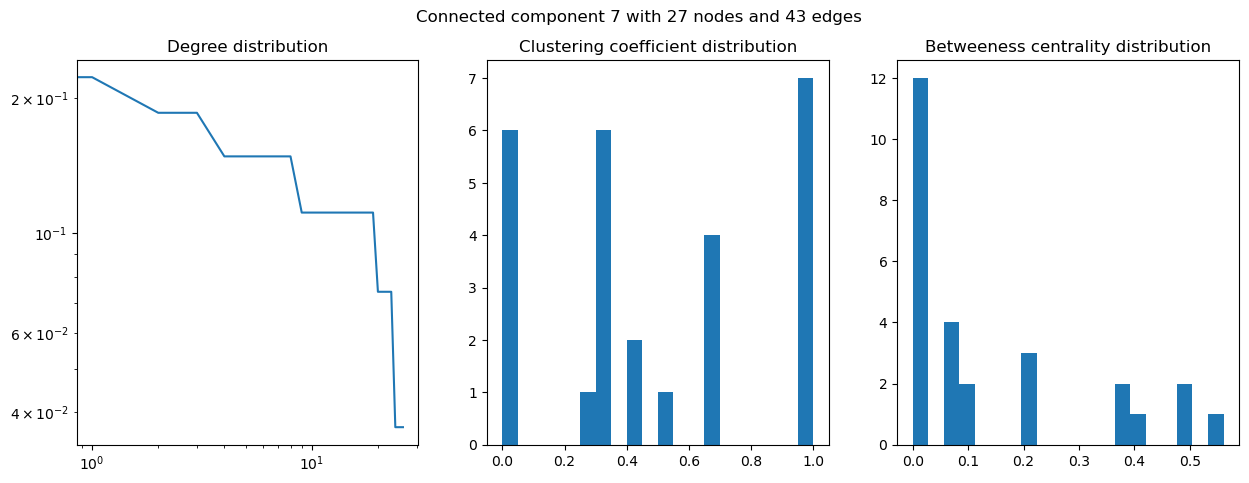

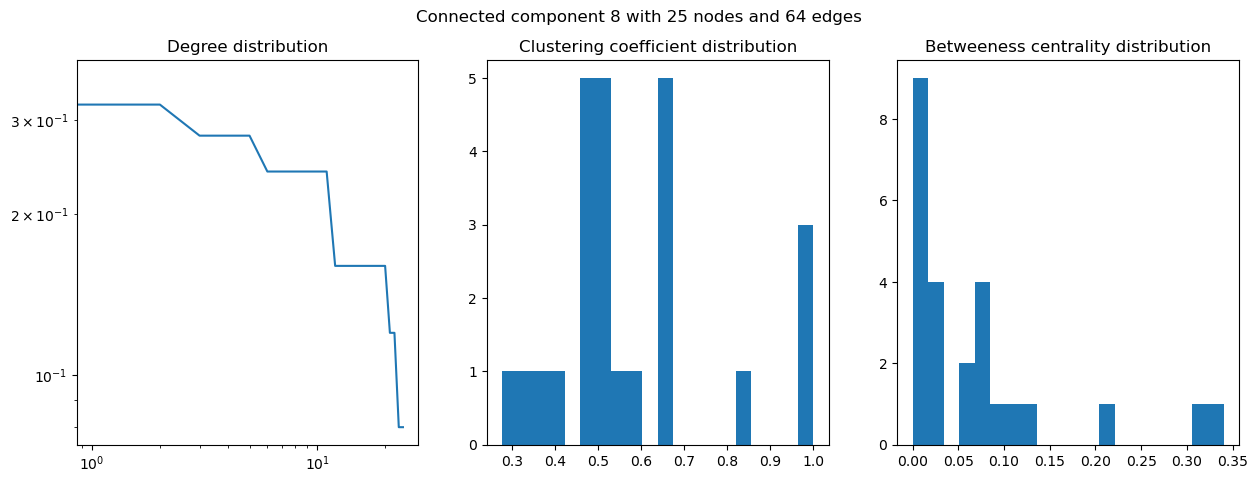

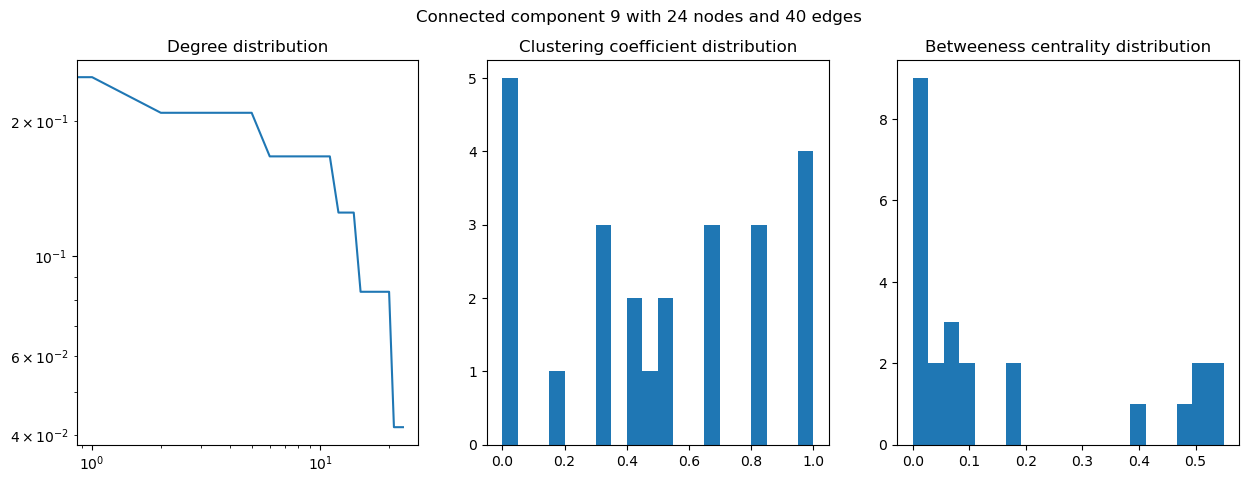

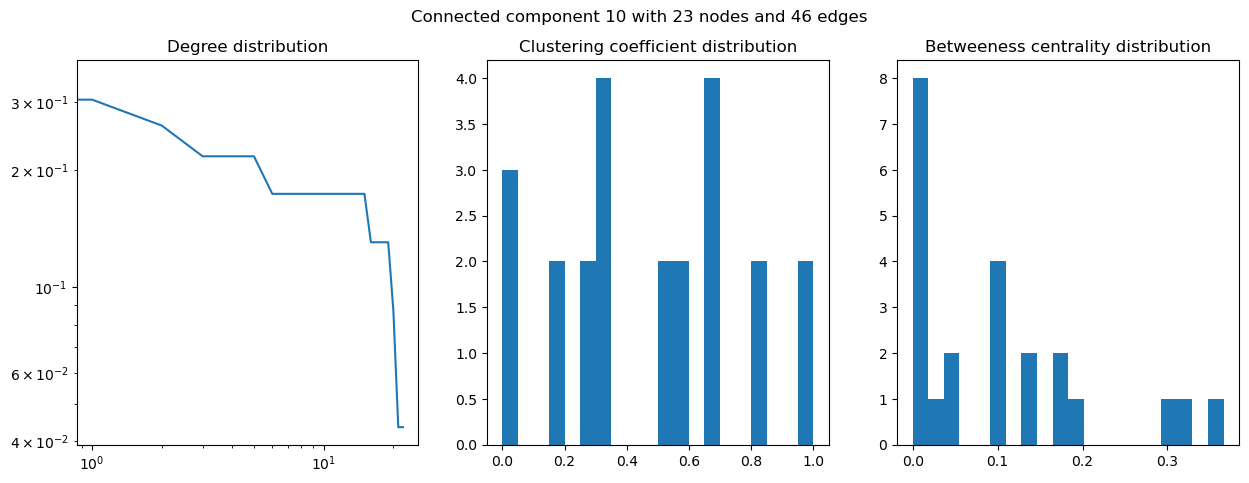

In [134]:
print("Creating...")
G = create_graph(df, tags_dict, 't3_p007p_f007p', 3, [['pages', 0.07, 'p'], ['followers', 0.07, 'p']])
# analyze newly created graph
print("Analyzing...")
analyze_distribution(G, 'Original Network')
